In [13]:
# Installing specified versions to ensure compatibility
!pip install qiskit==1.4.2 qiskit-machine-learning==0.8.2 qiskit_algorithms
!pip install pandas numpy matplotlib scikit-learn tensorflow qiskit
!pip install pylatexenc

# Import Qiskit and Qiskit Machine Learning modules after installation
import os
from PIL import Image
import pylatexenc
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [14]:
# --------------------- Mount Google Drive & Import Libraries ---------------------
from google.colab import drive
drive.mount('/content/drive')

# --------------------- Preprocessing Functions ---------------------
def load_images_from_folder(folder_path, label):
    """
    Loads images from a given folder, converts them to grayscale,
    resizes to 16x16, flattens and normalizes pixel intensities.
    Returns a list of processed images and corresponding labels.
    """
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.JPG', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            # Convert image to grayscale if not already
            img = img.convert('L')
            # Resize image to 16x16 pixels (you can choose a different target size)
            img = img.resize((16, 16), Image.BILINEAR)
            # Convert to numpy array and flatten to obtain a feature vector
            img_array = np.array(img).flatten().astype(np.float32)
            # Normalize pixel values to [0,1]
            img_array = img_array / 255.0
            images.append(img_array)
            labels.append(label)
    return images, labels

# Define your folder structure (modify the path as needed)
folder_Calculus  = "/content/drive/MyDrive/Colab Notebooks/data/calculus"
folder_hypodontia = "/content/drive/MyDrive/Colab Notebooks/data/hypodontia"

# Load images from each subfolder and assign labels:
# Let "Calculus" be labeled as +1 and "hypodontia" be labeled as -1.
Calculus_images, Calculus_labels   = load_images_from_folder(folder_Calculus, 1)
hypodontia_images, hypodontia_labels = load_images_from_folder(folder_hypodontia, -1)

# Combine the two lists:
all_images  = Calculus_images + hypodontia_images  # each image has shape (256,)
all_labels  = Calculus_labels + hypodontia_labels  # numeric labels: +1, -1

# Convert lists to NumPy arrays:
all_images = np.array(all_images)  # shape: (n_samples, 256)
all_labels = np.array(all_labels)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


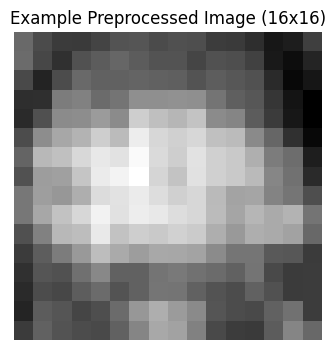

In [15]:
# --------------------- Dimensionality Reduction and Normalization ---------------------
# Use PCA to reduce dimensionality from 256 features (16x16 image) to 8 features.
pca = PCA(n_components=8)
all_images_reduced = pca.fit_transform(all_images)

# Normalize each resulting vector to unit length for amplitude encoding.
norms = np.linalg.norm(all_images_reduced, axis=1, keepdims=True)
all_images_normalized = all_images_reduced / norms

# --------------------- Split into Training and Testing Sets ---------------------
x_train, x_test, y_train, y_test = train_test_split(
    all_images_normalized, all_labels, test_size=0.3, random_state=42
)

# You can inspect one sample by reshaping it back for visualization (if desired):
plt.figure(figsize=(4, 4))
plt.imshow(all_images[0].reshape(16, 16), cmap='gray')
plt.title("Example Preprocessed Image (16x16)")
plt.axis("off")
plt.show()



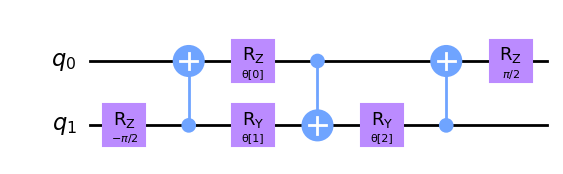

In [16]:
# --------------------- QCNN Model Definition ---------------------
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi/2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi/2, 0)
    return target

# Draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

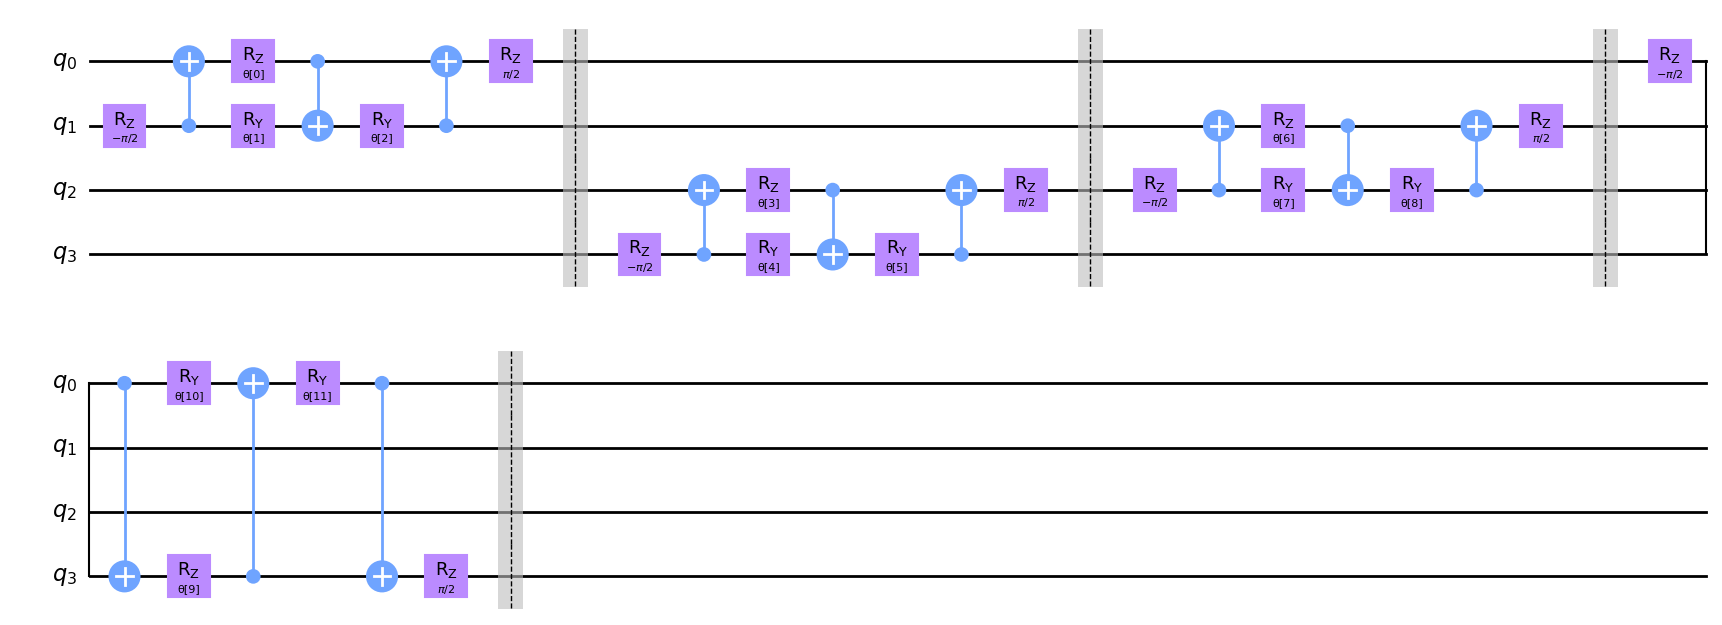

In [17]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index:(param_index+3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index:(param_index+3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

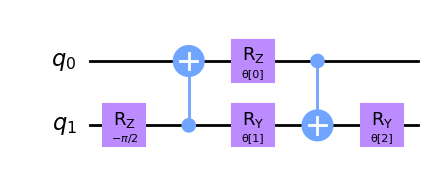

In [18]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi/2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

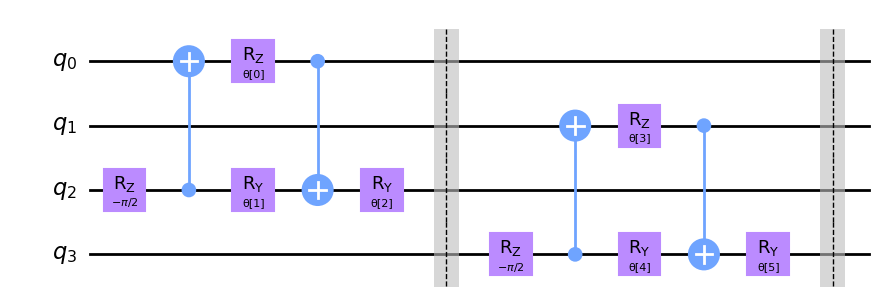

In [19]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=(num_qubits // 2) * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index:(param_index+3)]), [source, sink])
        qc.barrier()
        param_index += 3
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, list(range(num_qubits)))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

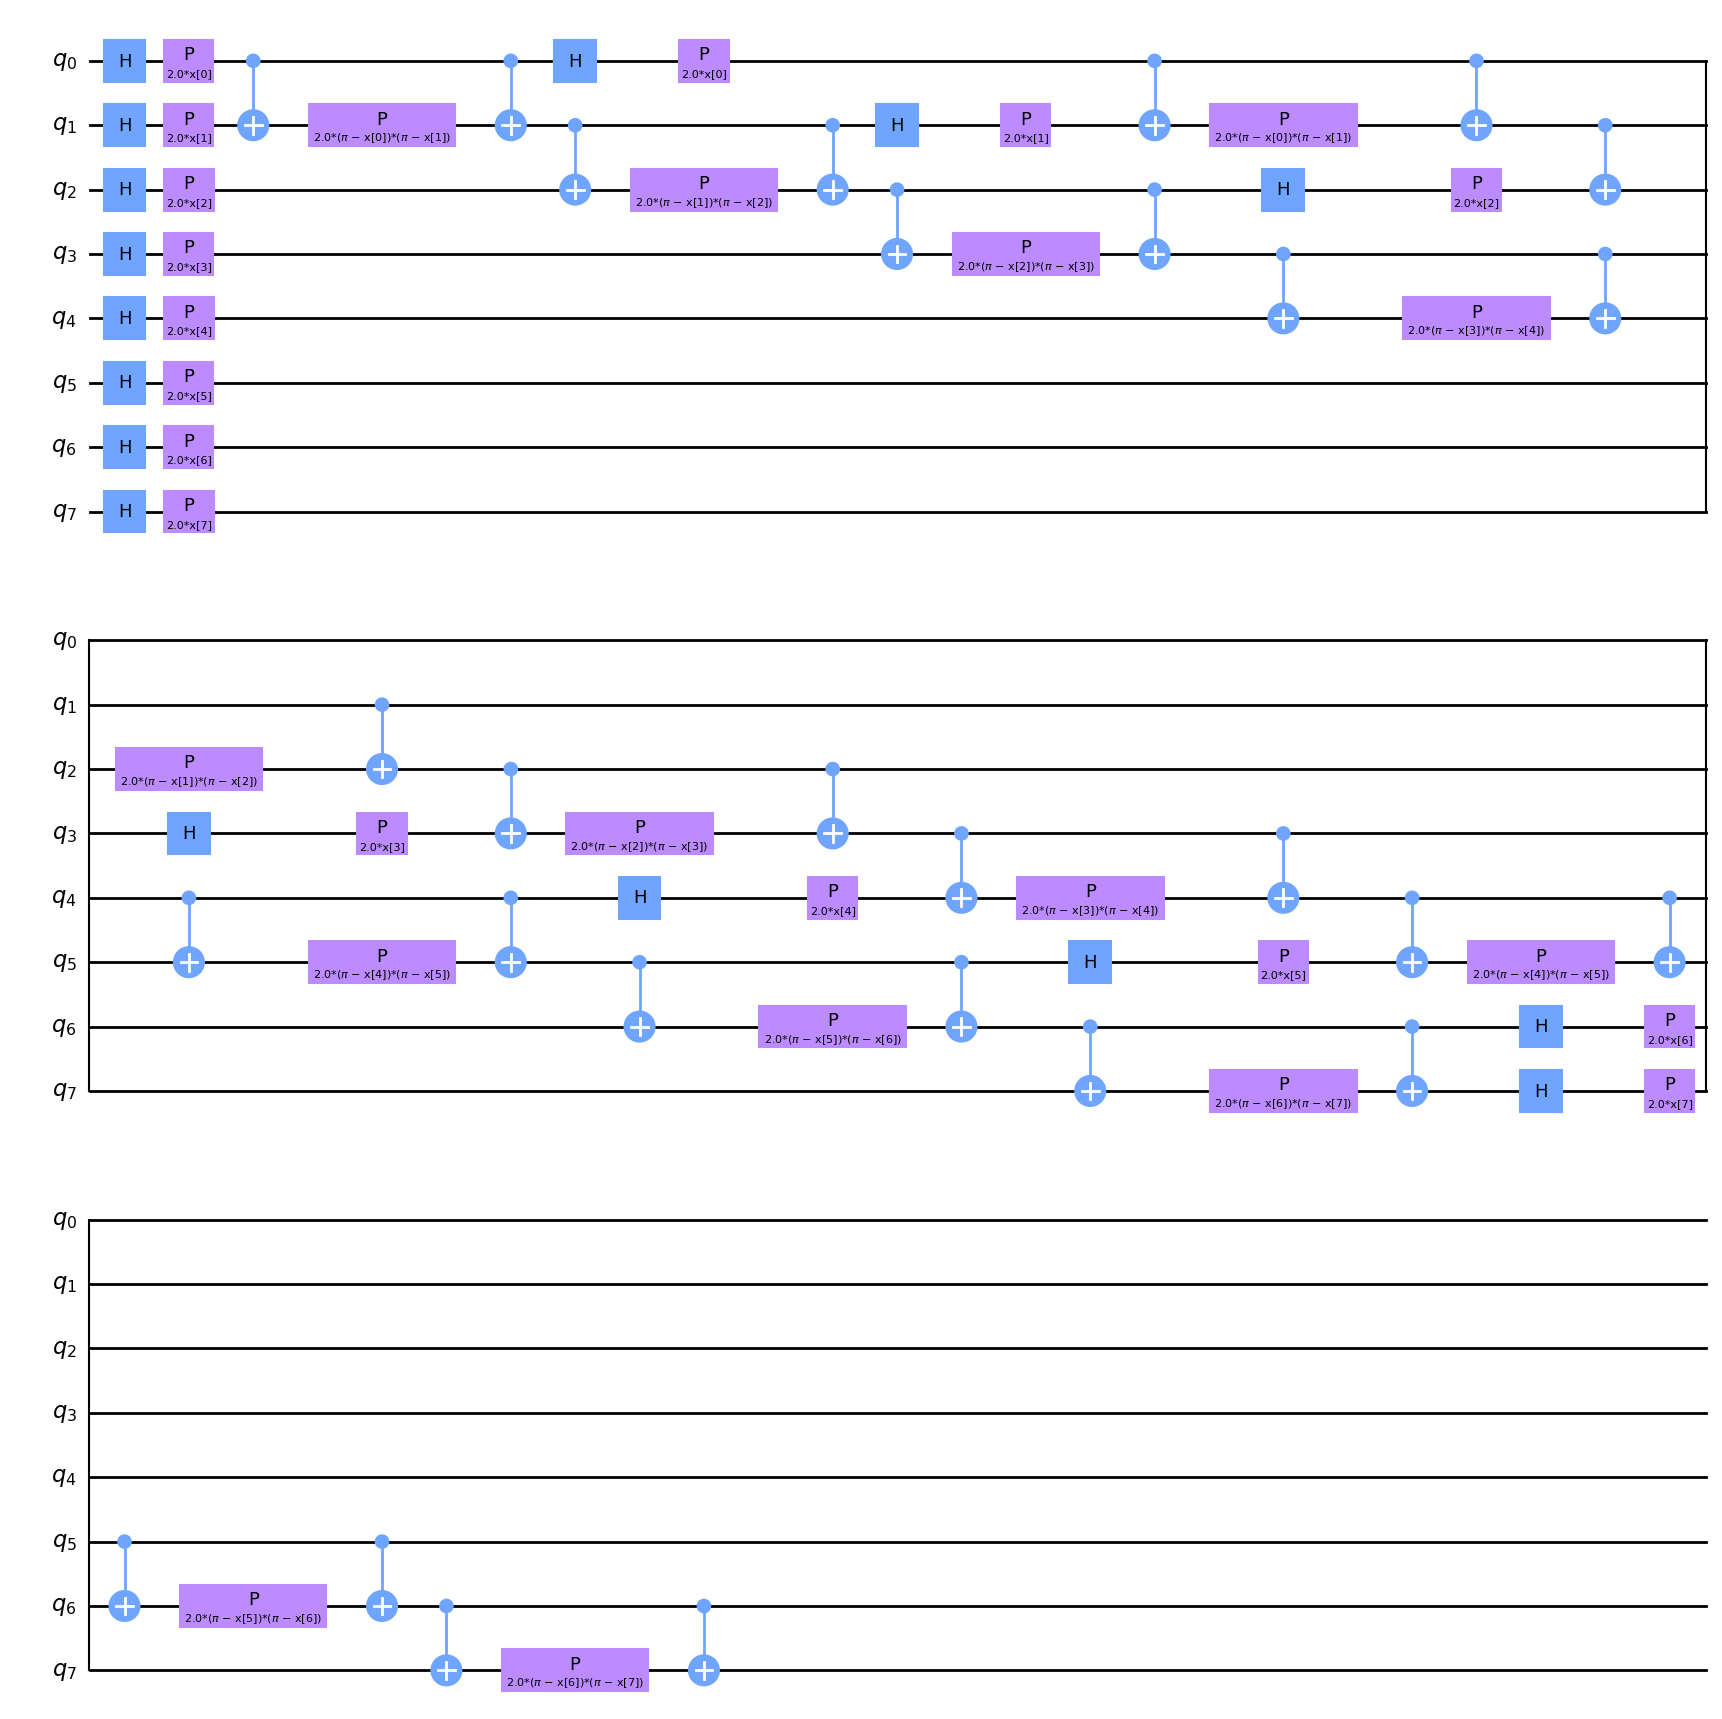

In [20]:
feature_map = ZZFeatureMap(8, reps=2, entanglement='linear')
feature_map.decompose().draw("mpl", style="clifford")

In [21]:
# Build the ansatz and full QCNN.
ansatz = QuantumCircuit(8, name="Ansatz")
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combine feature map and ansatz:
feature_map = ZZFeatureMap(8, reps=2, entanglement='linear')  # this matches our preprocessed input dimensionality
circuit = QuantumCircuit(8)
circuit.compose(feature_map, list(range(8)), inplace=True)
circuit.compose(ansatz, list(range(8)), inplace=True)

# Define the observable used for classification
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# Instantiate the QCNN using the estimator QNN.
estimator = Estimator()
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

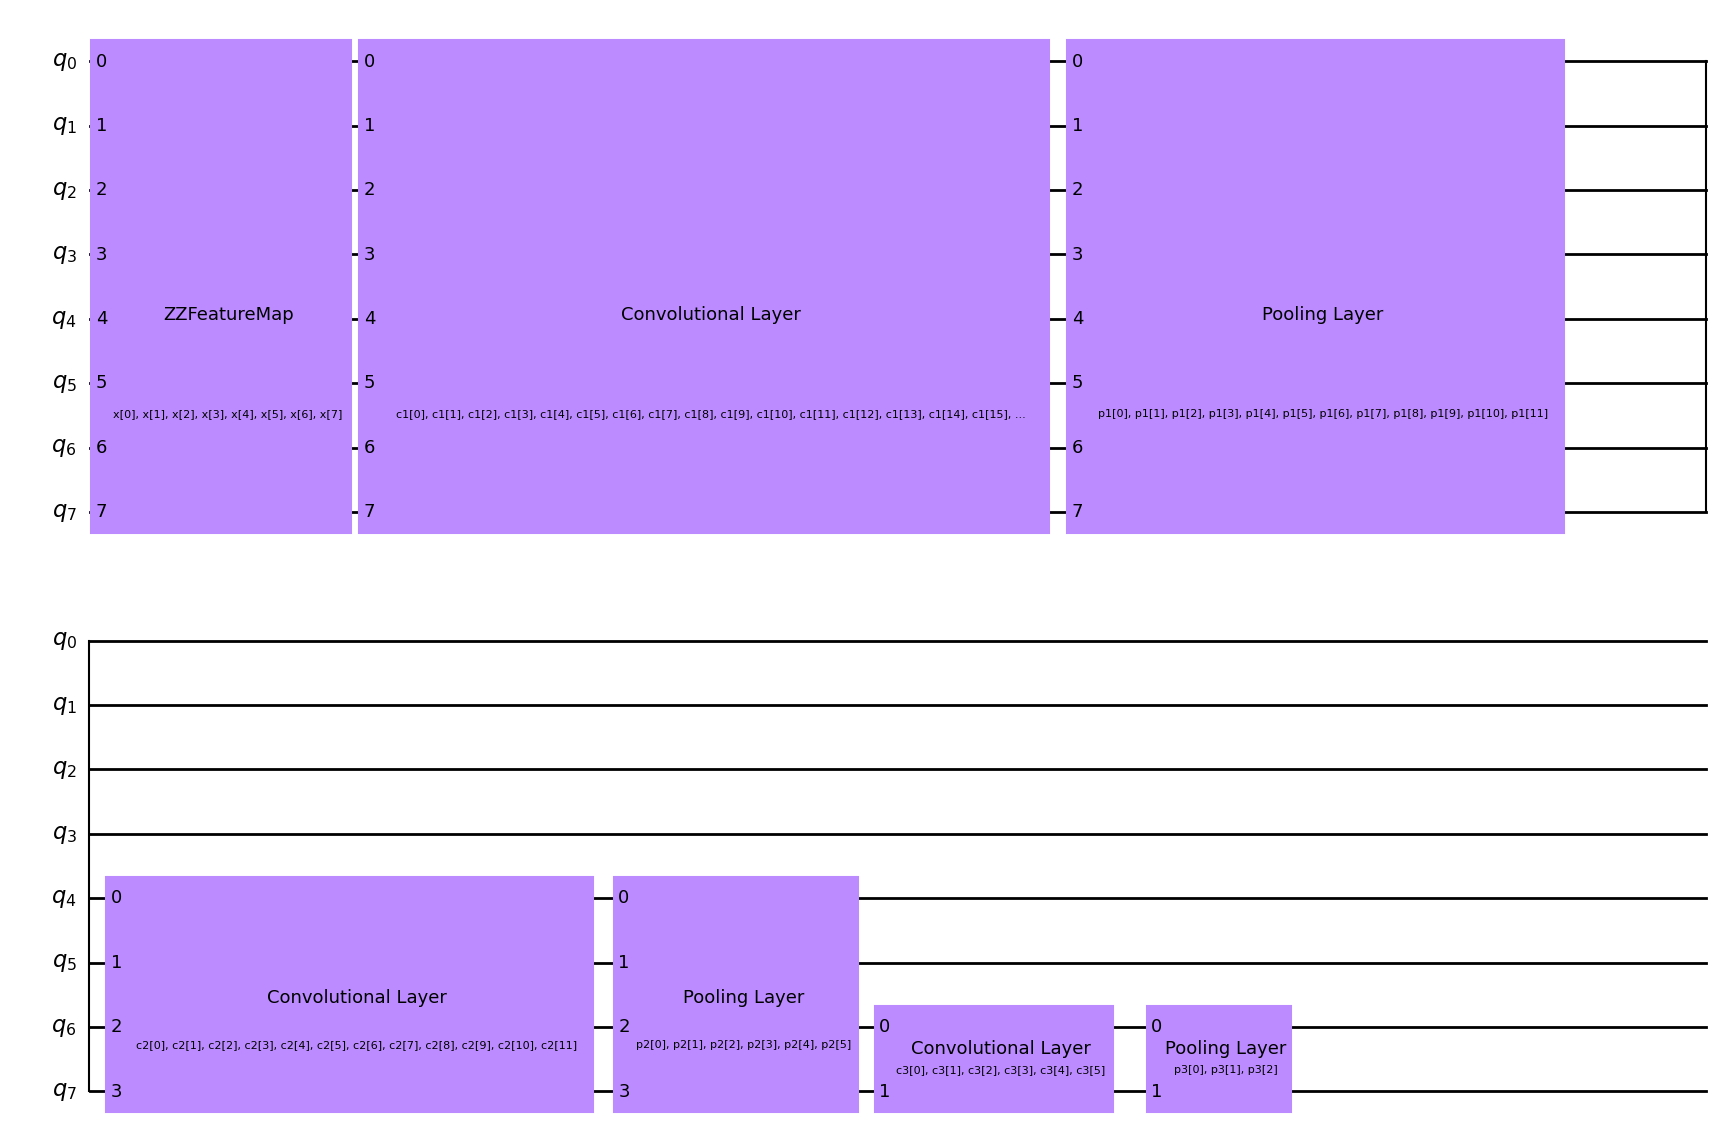

In [22]:
circuit.draw("mpl", style="clifford")

Accuracy on the training data: 57.3%
Accuracy on the test data: 56.02%


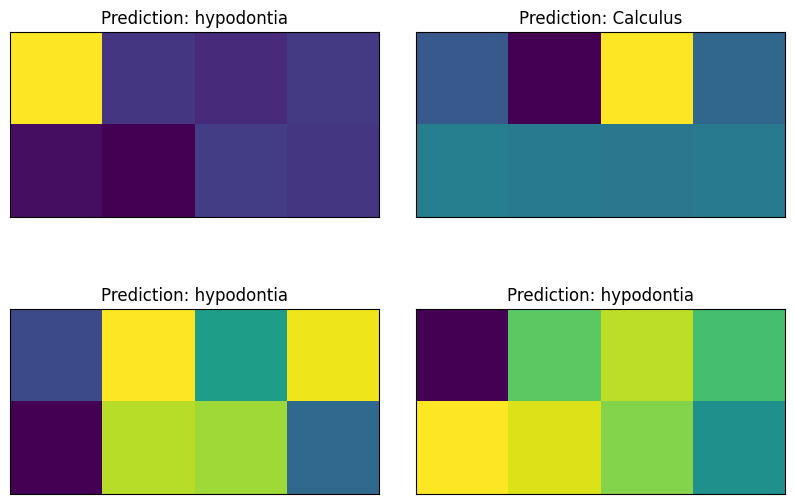

In [23]:
# Define a callback to monitor training.
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value vs. iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Load the initial parameter point (if available)
import json
try:
    with open("/content/drive/MyDrive/Colab Notebooks/data/11_qcnn_initial_point.json", "r") as f:
        initial_point = json.load(f)
except FileNotFoundError:
    print("Initial point file not found. Starting training without pre-loaded parameters.")
    initial_point = None # Set to None if the file isn't found

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph,
    initial_point=initial_point,
)

# --------------------- Train the QCNN on the Preprocessed Kidney Ultrasound Data ---------------------
x = np.asarray(x_train)  # shape should now be (n_samples, 8)
y = np.asarray(y_train)
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# Evaluate performance
print(f"Accuracy on the training data: {np.round(100 * classifier.score(x, y), 2)}%")
x_test_arr = np.asarray(x_test)
y_test_arr = np.asarray(y_test)
print(f"Accuracy on the test data: {np.round(100 * classifier.score(x_test_arr, y_test_arr), 2)}%")

# Optionally, display a few test images and their predicted classes.
y_predict = classifier.predict(x_test_arr)
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    # To show the preprocessed version, map it back to 16x16 shape using PCA inverse transform, if desired.
    # Here we simply show the 8-feature vector reshaped to 2x4 for visualization.
    ax[i//2, i%2].imshow(x_test_arr[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i//2, i%2].set_title("Prediction: hypodontia")
    elif y_predict[i] == 1:
        ax[i//2, i%2].set_title("Prediction: Calculus")
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

Macro F1 Score: 0.5457
Macro Precision Score: 0.5465
Macro Recall Score: 0.5463
AUROC Score: 0.5463


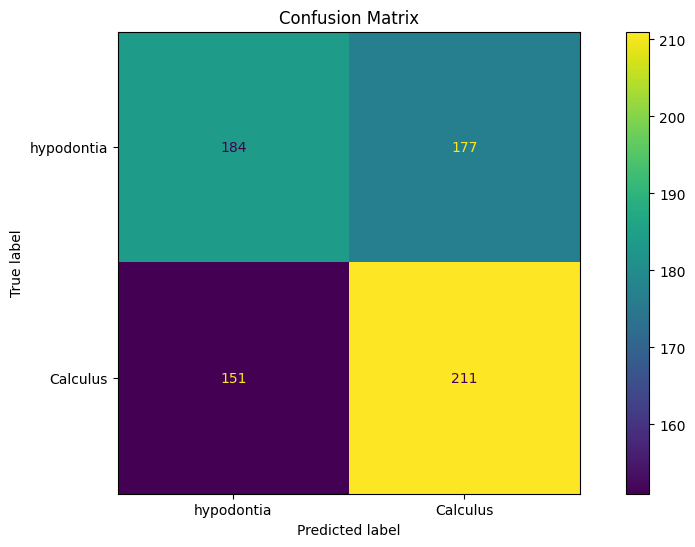

In [24]:
# Calculate Macro-F1, Precision, Recall, and AUROC
f1_macro = f1_score(y_test_arr, y_predict, average='macro')
precision_macro = precision_score(y_test_arr, y_predict, average='macro')
recall_macro = recall_score(y_test_arr, y_predict, average='macro')

# Since the output is -1 or 1, we can adjust the labels for roc_auc_score
# Assuming y_test_arr and y_predict are -1 and 1, we can map them to 0 and 1 for roc_auc_score
y_test_binary = (y_test_arr + 1) / 2
y_predict_binary = (y_predict + 1) / 2

# Calculate AUROC using the binary predicted labels
auroc = roc_auc_score(y_test_binary, y_predict_binary)

print(f"Macro F1 Score: {np.round(f1_macro, 4)}")
print(f"Macro Precision Score: {np.round(precision_macro, 4)}")
print(f"Macro Recall Score: {np.round(recall_macro, 4)}")
print(f"AUROC Score: {np.round(auroc, 4)}")

# Calculate and display Confusion Matrix
cm = confusion_matrix(y_test_arr, y_predict, labels=[-1, 1]) # Specify labels to ensure order
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hypodontia", "Calculus"]) # Display labels for clarity

disp.plot()
plt.title("Confusion Matrix")
plt.show()